In [106]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
import openmeteo_requests 
from openmeteo_requests import Client
import requests_cache
from retry_requests import retry


**For Karachi**

In [109]:
# API Key and City Name
API_KEY = '5bdede423214bc661bc2c20f401a0e14'
CITY = 'karachi'

url = f"http://api.openweathermap.org/geo/1.0/direct?q={CITY},PK&limit=5&appid={API_KEY}"
# Make the API request
response = requests.get(url)
raw = response.json()

In [111]:
# Extract latitude and longitude
latitude = raw[0]["lat"]
longitude = raw[0]["lon"]
print(f"Latitude: {latitude}, Longitude: {longitude}")

Latitude: 24.8546842, Longitude: 67.0207055


In [113]:
#Set time range for air pollution data
current_datetime = datetime.now(timezone.utc)  # Current UTC time as timezone-aware
current_unix_time = int(current_datetime.timestamp())  # Current time in UNIX format

start_datetime = current_datetime - timedelta(days=365)  # Start time 1 year ago
start_unix_time = int(start_datetime.timestamp())

**Air Pollution Data**

In [116]:
#Fetch air pollution data
pollution_url = (
        f"http://api.openweathermap.org/data/2.5/air_pollution/history?"
        f"lat={latitude}&lon={longitude}&start={start_unix_time}&end={current_unix_time}&appid={API_KEY}"
)
pollution_response = requests.get(pollution_url)
pollution_data = pollution_response.json()

In [118]:
#Check for 'list' key in the response
if "list" in pollution_data:
        print("Air pollution data retrieved successfully!")
else:
        print(f"Error: {pollution_data}")

Air pollution data retrieved successfully!


In [120]:
karachi = pd.json_normalize(pollution_data["list"])
print(karachi)

              dt  main.aqi  components.co  components.no  components.no2  \
0     1706022000         5        1361.85           0.00           61.69   
1     1706025600         5        2216.34           2.32           90.48   
2     1706029200         5        4165.65          33.53          111.04   
3     1706032800         5        8117.68         103.71          139.83   
4     1706036400         5       13031.01         173.45          197.41   
...          ...       ...            ...            ...             ...   
8635  1737540000         3         413.90           1.13            6.94   
8636  1737543600         3         397.21           1.02            7.28   
8637  1737547200         3         407.22           0.79            9.17   
8638  1737550800         3         907.90           0.58           34.62   
8639  1737554400         4        1428.60           0.00           56.21   

      components.o3  components.so2  components.pm2_5  components.pm10  \
0            

In [122]:
#Convert Unix Timestamps to Readable Date/Time
karachi['dt'] = pd.to_datetime(karachi['dt'], unit='s')
karachi.set_index('dt', inplace=True)

karachi.sort_values(by='dt', ascending=True)

,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3
dt,,,,,,,,,
2024-01-23 15:00:00,5,1361.85,0.00,61.69,59.37,35.29,75.45,142.08,14.19
2024-01-23 16:00:00,5,2216.34,2.32,90.48,20.38,38.62,109.09,179.84,29.39
2024-01-23 17:00:00,5,4165.65,33.53,111.04,0.06,46.25,208.32,295.13,57.76
2024-01-23 18:00:00,5,8117.68,103.71,139.83,0.00,66.76,439.62,561.32,106.39
2024-01-23 19:00:00,5,13031.01,173.45,197.41,0.00,86.78,737.33,907.86,151.99
...,...,...,...,...,...,...,...,...,...
2025-01-22 10:00:00,3,413.90,1.13,6.94,134.47,7.15,22.58,47.75,3.26
2025-01-22 11:00:00,3,397.21,1.02,7.28,124.45,6.97,19.63,41.86,2.95
2025-01-22 12:00:00,3,407.22,0.79,9.17,117.30,7.45,18.36,38.50,2.88


**Weather Data**

In [125]:
current = datetime.now(timezone.utc).date() - timedelta(days=365 + 5)
end = datetime.now(timezone.utc).date() - timedelta(days=5)

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = Client(session=retry_session)

# Define the API parameters
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 24.8546842,
    "longitude": 67.0207055,
    "start_date": current,
    "end_date": end,
    "hourly": ["temperature_2m", "relative_humidity_2m"]
}

# Make API call
responses = openmeteo.weather_api(url, params=params)

# Process the first response
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ),
    "temperature_2m": hourly_temperature_2m,
    "relative_humidity_2m": hourly_relative_humidity_2m
}

hourly_dataframe = pd.DataFrame(data=hourly_data)
hourly_dataframe["date"] = pd.to_datetime(hourly_dataframe["date"]).dt.tz_localize(None)
print(hourly_dataframe)

# Forecasting setup
start_date = datetime.now(timezone.utc) - timedelta(days=5)
end_date = datetime.now(timezone.utc)

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 24.8546842,
    "longitude": 67.0207055,
    "hourly": ["temperature_2m", "relative_humidity_2m"],
    "start_date": start_date.strftime("%Y-%m-%d"),
    "end_date": end_date.strftime("%Y-%m-%d")
}

responses = openmeteo.weather_api(url, params=params)

# Process forecast response
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ),
    "temperature_2m": hourly_temperature_2m,
    "relative_humidity_2m": hourly_relative_humidity_2m
}

dataframe = pd.DataFrame(data=hourly_data)
print(dataframe)


Coordinates 24.850614547729492°N 66.99248504638672°E
Elevation 8.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                    date  temperature_2m  relative_humidity_2m
0    2024-01-18 00:00:00       16.500000             63.928204
1    2024-01-18 01:00:00       15.700000             67.955162
2    2024-01-18 02:00:00       15.150000             69.456673
3    2024-01-18 03:00:00       15.450000             66.997360
4    2024-01-18 04:00:00       17.450001             58.008617
...                  ...             ...                   ...
8779 2025-01-17 19:00:00       17.500000             44.433994
8780 2025-01-17 20:00:00       17.350000             42.423756
8781 2025-01-17 21:00:00       17.200001             41.063839
8782 2025-01-17 22:00:00       16.850000             42.280239
8783 2025-01-17 23:00:00       16.400000             46.011971

[8784 rows x 3 columns]
Coordinates 24.875°N 67.0°E
Elevation 8.0 m asl
Timezone None None
Timezone difference to GMT+

In [127]:
hourly_dataframe["date"] = pd.to_datetime(hourly_dataframe["date"]).dt.tz_localize(None)

In [129]:
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m
0,2024-01-18 00:00:00,16.500000,63.928204
1,2024-01-18 01:00:00,15.700000,67.955162
2,2024-01-18 02:00:00,15.150000,69.456673
3,2024-01-18 03:00:00,15.450000,66.997360
4,2024-01-18 04:00:00,17.450001,58.008617


**Data Concatenation**

In [132]:
final_df = pd.merge(karachi, hourly_dataframe, right_on="date", left_on= "dt", how="inner")
final_df.set_index("date", inplace=True)

In [134]:
final_df.head()

,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,temperature_2m,relative_humidity_2m
date,,,,,,,,,,,
2024-01-23 15:00:00,5,1361.85,0.00,61.69,59.37,35.29,75.45,142.08,14.19,21.000000,69.240685
2024-01-23 16:00:00,5,2216.34,2.32,90.48,20.38,38.62,109.09,179.84,29.39,20.049999,74.366936
2024-01-23 17:00:00,5,4165.65,33.53,111.04,0.06,46.25,208.32,295.13,57.76,19.600000,64.190186
2024-01-23 18:00:00,5,8117.68,103.71,139.83,0.00,66.76,439.62,561.32,106.39,19.100000,52.304653
2024-01-23 19:00:00,5,13031.01,173.45,197.41,0.00,86.78,737.33,907.86,151.99,17.799999,56.171726


In [136]:
final_df.to_csv("karachi_air_pollution_data.csv", index=True)

**Data Preprocessing**

In [139]:
# Check for missing values
print(final_df.isnull().sum())

main.aqi                0
components.co           0
components.no           0
components.no2          0
components.o3           0
components.so2          0
components.pm2_5        0
components.pm10         0
components.nh3          0
temperature_2m          0
relative_humidity_2m    0
dtype: int64


In [141]:
# Check for duplicates
print(final_df.duplicated().sum())

0


In [143]:
print(final_df.shape)

(8529, 11)


**Feature Engineering**

**Date-Time Features**

In [147]:
#Additional columns
final_df['date'] = final_df.index.date
final_df['time'] = final_df.index.time
final_df['day'] = final_df.index.day
final_df['month'] = final_df.index.month
final_df['year'] = final_df.index.year
final_df['hour'] = final_df.index.hour
final_df['day_of_week'] = final_df.index.dayofweek
final_df['is_weekend'] = final_df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

**Categorizing AQI levels**

In [150]:
aqi_mapping = {
    1: 'Good',
    2: 'Fair',
    3: 'Moderate',
    4: 'Poor',
    5: 'Very Poor'
}
final_df['aqi_category'] = final_df['main.aqi'].map(aqi_mapping)

**Lag Features**

In [153]:
# Adding lag features
final_df['aqi_lag_1'] = final_df['main.aqi'].shift(1)
final_df['aqi_lag_2'] = final_df['main.aqi'].shift(2)
final_df['aqi_lag_3'] = final_df['main.aqi'].shift(3)

**Rolling features**

In [156]:
# Rolling averages for AQI
final_df['aqi_rolling_mean_3'] = final_df['main.aqi'].rolling(window=3).mean()
final_df['aqi_rolling_mean_7'] = final_df['main.aqi'].rolling(window=7).mean()

**Interaction Terms**

In [159]:
# Interaction terms
final_df['co_pm2_5_interaction'] = final_df['components.co'] * final_df['components.pm2_5']
final_df['temperature_humidity_interaction'] = final_df['temperature_2m'] * final_df['relative_humidity_2m']


**Normalization**

In [162]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_columns = ['main.aqi', 'components.co', 'components.pm2_5', 'temperature_2m', 'relative_humidity_2m']
final_df[scaled_columns] = scaler.fit_transform(final_df[scaled_columns])


**Post-Processing**

In [165]:
# Check for missing values
print(final_df.isnull().sum())

main.aqi                            0
components.co                       0
components.no                       0
components.no2                      0
components.o3                       0
components.so2                      0
components.pm2_5                    0
components.pm10                     0
components.nh3                      0
temperature_2m                      0
relative_humidity_2m                0
date                                0
time                                0
day                                 0
month                               0
year                                0
hour                                0
day_of_week                         0
is_weekend                          0
aqi_category                        0
aqi_lag_1                           1
aqi_lag_2                           2
aqi_lag_3                           3
aqi_rolling_mean_3                  2
aqi_rolling_mean_7                  6
co_pm2_5_interaction                0
temperature_

In [167]:
print(final_df['main.aqi'].unique())
print(final_df['aqi_category'].unique())

[1.   0.75 0.5  0.25 0.  ]
['Very Poor' 'Poor' 'Moderate' 'Fair' 'Good']


**Handling missing values**

In [170]:
final_df = final_df.bfill()  # Backfill missing values

In [172]:
# Check for missing values
print(final_df.isnull().sum())

main.aqi                            0
components.co                       0
components.no                       0
components.no2                      0
components.o3                       0
components.so2                      0
components.pm2_5                    0
components.pm10                     0
components.nh3                      0
temperature_2m                      0
relative_humidity_2m                0
date                                0
time                                0
day                                 0
month                               0
year                                0
hour                                0
day_of_week                         0
is_weekend                          0
aqi_category                        0
aqi_lag_1                           0
aqi_lag_2                           0
aqi_lag_3                           0
aqi_rolling_mean_3                  0
aqi_rolling_mean_7                  0
co_pm2_5_interaction                0
temperature_

In [69]:
final_df.to_csv("feature_engineered_karachi_air_pollution_data.csv", index=True)

In [174]:
# Ensure only numeric columns are used for correlation
numeric_df = final_df.select_dtypes(include=['number'])

# Calculate correlation of each feature with main_aqi
correlations = numeric_df.corr()["main.aqi"]

# Sort the correlations in descending order for better readability
correlations_sorted = correlations.sort_values(ascending=False)

# Display the sorted correlations
print("Correlation of each feature with main_aqi:")
print(correlations_sorted)

Correlation of each feature with main_aqi:
main.aqi                            1.000000
aqi_rolling_mean_3                  0.971696
aqi_lag_1                           0.950687
aqi_rolling_mean_7                  0.911579
aqi_lag_2                           0.899015
aqi_lag_3                           0.849255
components.pm2_5                    0.651239
components.so2                      0.624875
components.nh3                      0.579076
components.co                       0.576210
components.pm10                     0.499727
co_pm2_5_interaction                0.381130
components.no                       0.345581
year                                0.252430
components.no2                      0.174005
components.o3                       0.124087
day                                 0.047072
month                              -0.006663
day_of_week                        -0.039689
is_weekend                         -0.045384
hour                               -0.052317
temperature_

**Exploratory Data Analysis**

**Univariate Analysis**

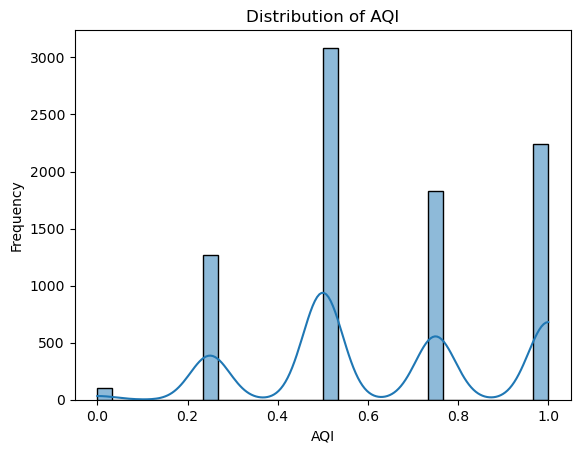

In [178]:
# Distribution of AQI
sns.histplot(final_df['main.aqi'], kde=True, bins=30)
plt.title('Distribution of AQI')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

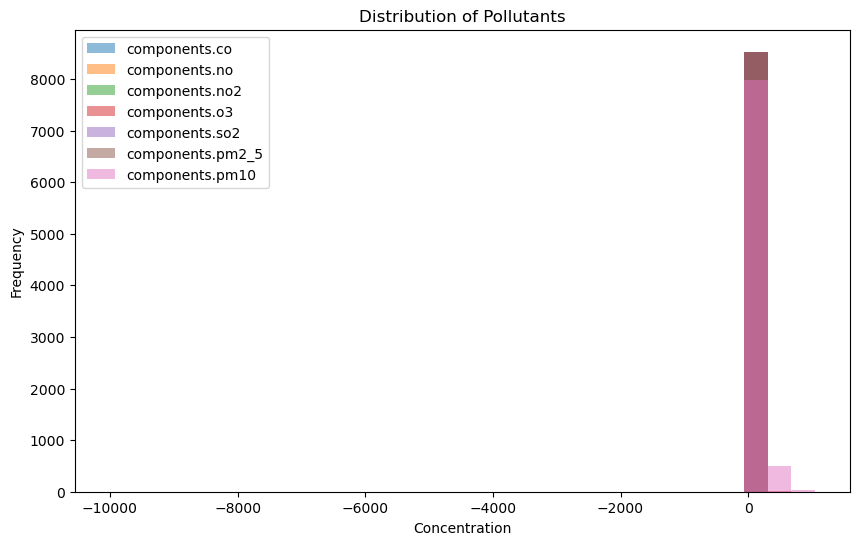

In [180]:
# Distribution of pollutants
pollutants = ['components.co', 'components.no', 'components.no2', 'components.o3', 'components.so2', 'components.pm2_5', 'components.pm10']
final_df[pollutants].plot(kind='hist', bins=30, alpha=0.5, figsize=(10, 6))
plt.title('Distribution of Pollutants')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

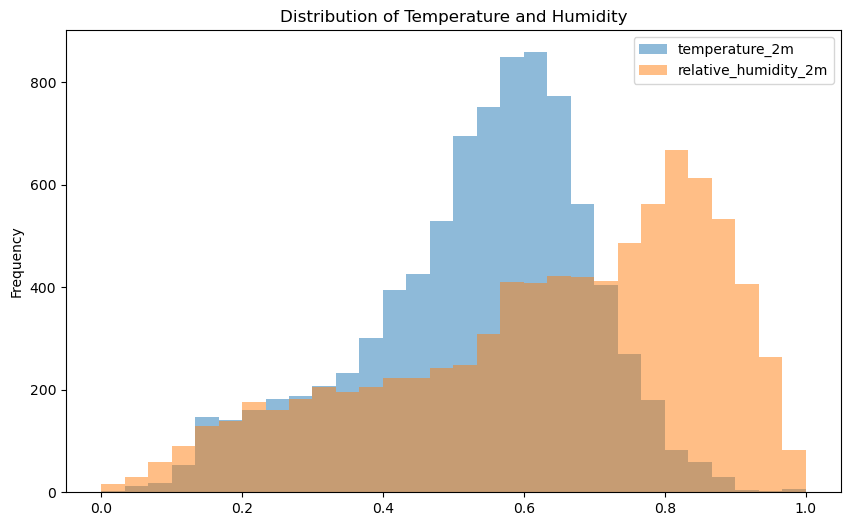

In [182]:
# Distribution of temperature and humidity
final_df[['temperature_2m', 'relative_humidity_2m']].plot(kind='hist', bins=30, alpha=0.5, figsize=(10, 6))
plt.title('Distribution of Temperature and Humidity')
plt.show()

**Time-series Analaysis**

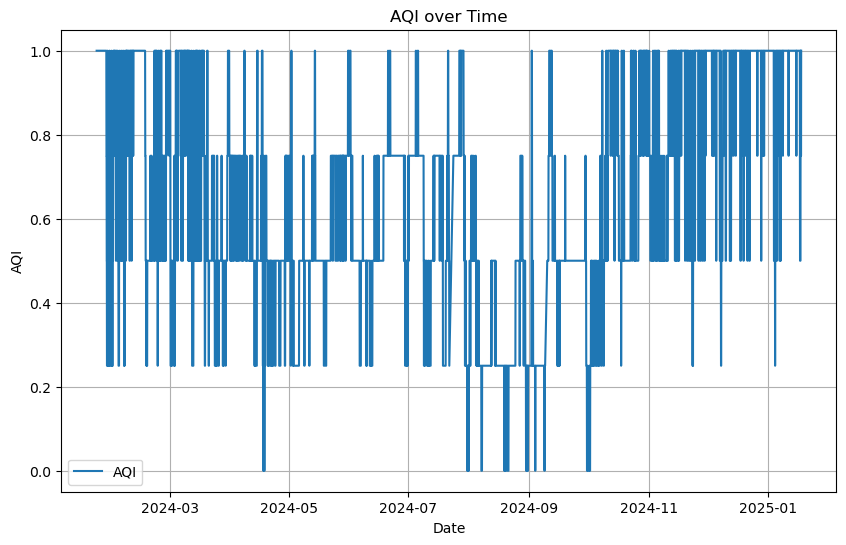

In [185]:
# Plot AQI over time
plt.figure(figsize=(10, 6))
plt.plot(final_df.index, final_df['main.aqi'], label='AQI')
plt.title('AQI over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(True)
plt.legend()
plt.show()


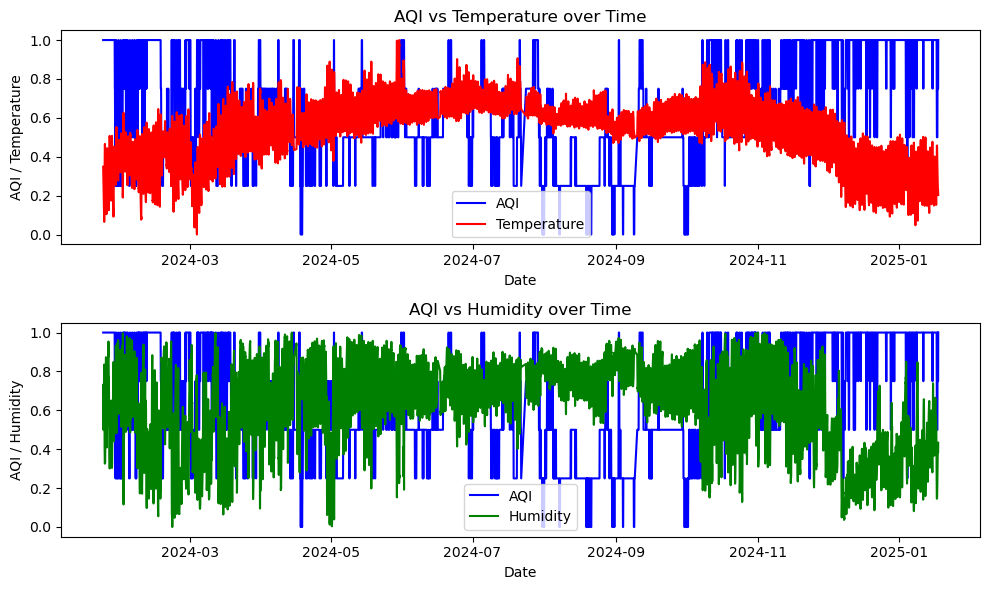

In [187]:
# Plot AQI vs temperature and humidity
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# AQI vs Temperature
axs[0].plot(final_df.index, final_df['main.aqi'], label='AQI', color='b')
axs[0].plot(final_df.index, final_df['temperature_2m'], label='Temperature', color='r')
axs[0].set_title('AQI vs Temperature over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('AQI / Temperature')
axs[0].legend()

# AQI vs Humidity
axs[1].plot(final_df.index, final_df['main.aqi'], label='AQI', color='b')
axs[1].plot(final_df.index, final_df['relative_humidity_2m'], label='Humidity', color='g')
axs[1].set_title('AQI vs Humidity over Time')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('AQI / Humidity')
axs[1].legend()

plt.tight_layout()
plt.show()

**Correlation Analysis**

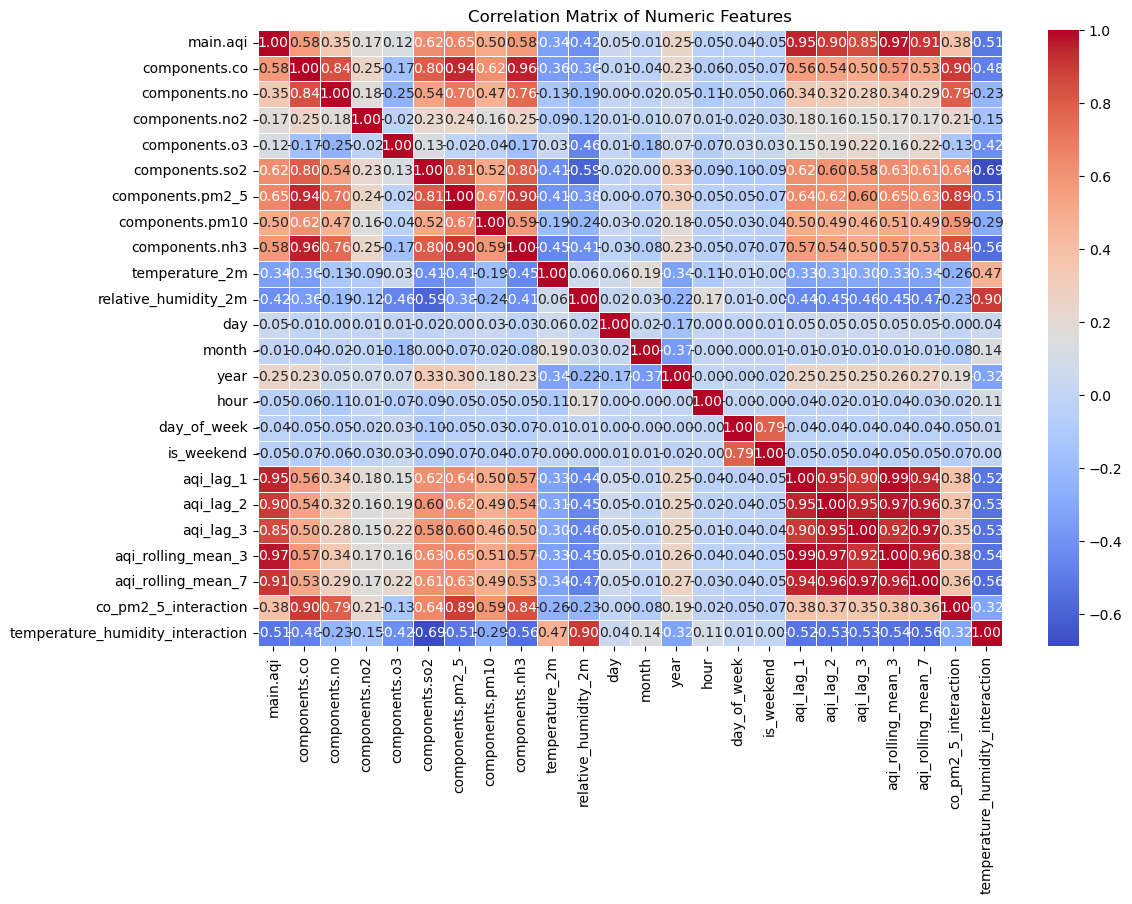

In [190]:
# Select only numeric columns
numeric_df = final_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


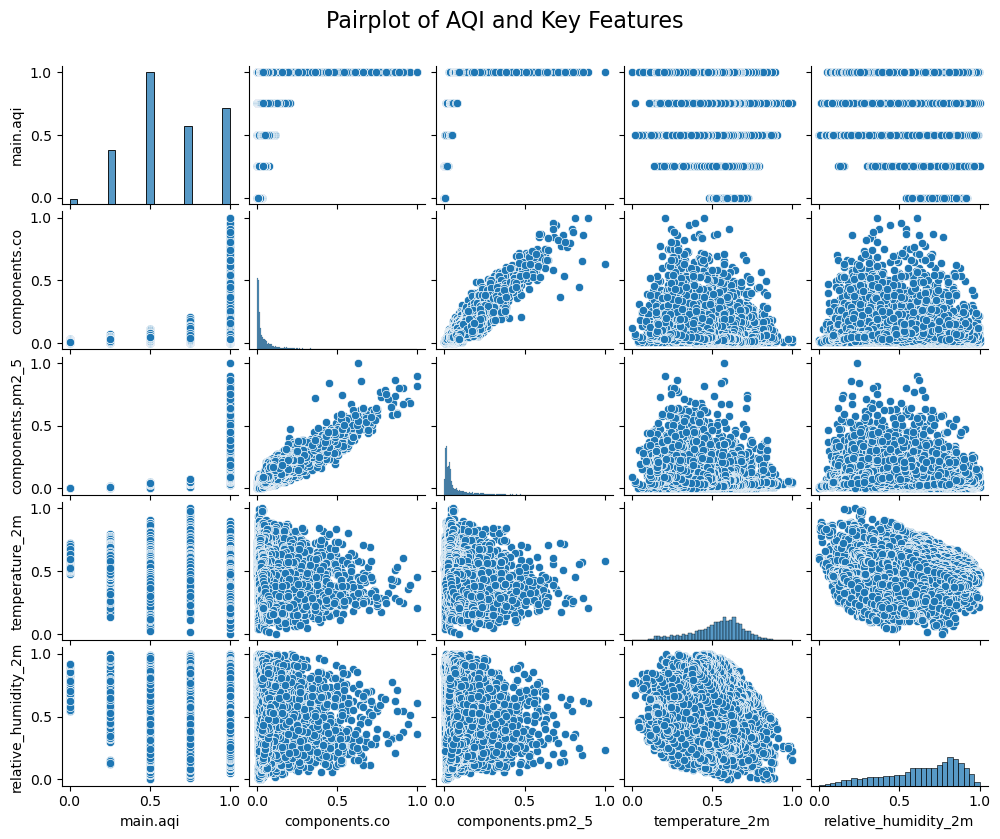

In [191]:
# Plot pairplot
sns.pairplot(final_df[['main.aqi', 'components.co', 'components.pm2_5', 'temperature_2m', 'relative_humidity_2m']])
# Adjust the figure size and title position
plt.gcf().set_size_inches(10, 8)  # size of the plot
plt.subplots_adjust(top=0.95)  # Adjust the top to ensure the title is visible
plt.suptitle('Pairplot of AQI and Key Features', fontsize=16, y=1.02)  # Title and position it slightly above the plot
plt.show()

**Seasonality & Trends Over Time**

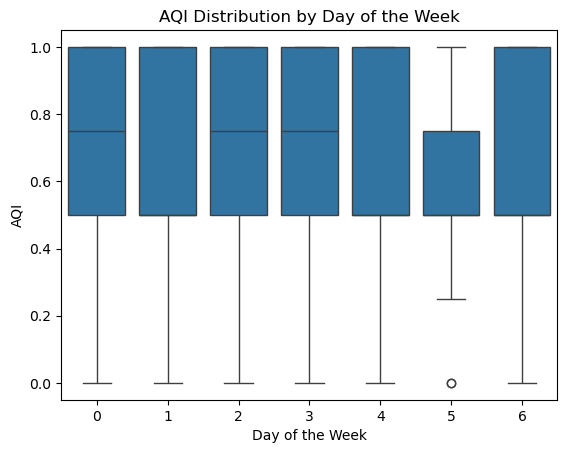

In [194]:
# AQI by day of the week
sns.boxplot(x='day_of_week', y='main.aqi', data=final_df)
plt.title('AQI Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('AQI')
plt.show()

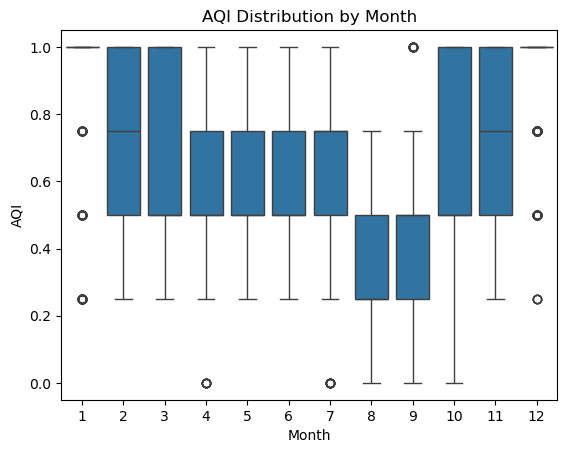

In [195]:
# AQI by month
sns.boxplot(x='month', y='main.aqi', data=final_df)
plt.title('AQI Distribution by Month')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.show()

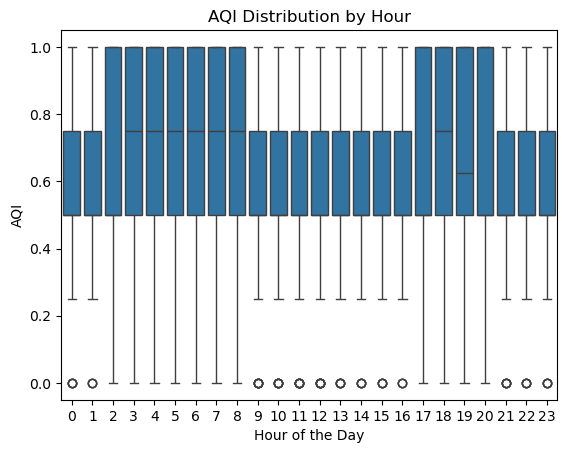

In [199]:
# AQI by hour
sns.boxplot(x='hour', y='main.aqi', data=final_df)
plt.title('AQI Distribution by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('AQI')
plt.show()

**Analyzing AQI Categories**

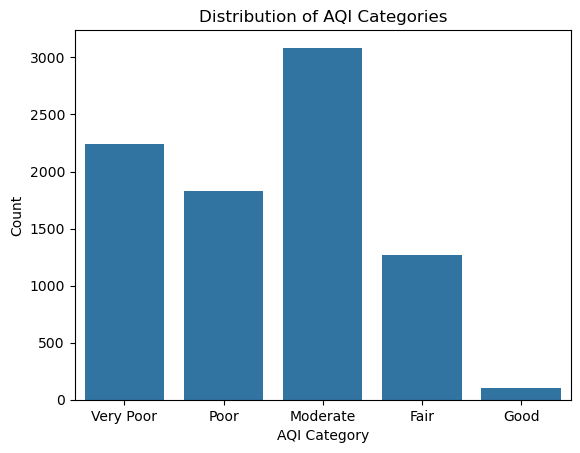

In [202]:
# Count of AQI Categories
sns.countplot(x='aqi_category', data=final_df)
plt.title('Distribution of AQI Categories')
plt.xlabel('AQI Category')
plt.ylabel('Count')
plt.show()

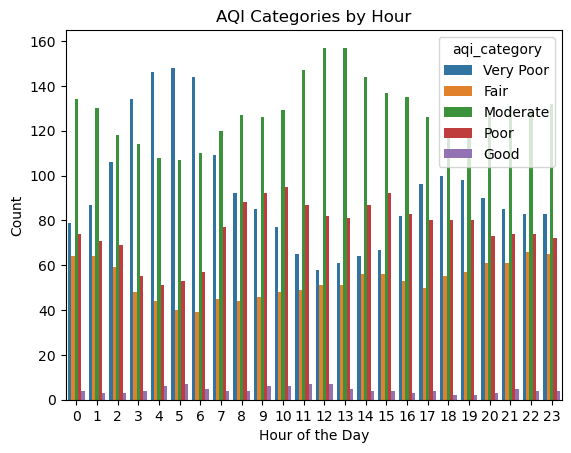

In [204]:
# AQI Categories by Hour
sns.countplot(x='hour', hue='aqi_category', data=final_df)
plt.title('AQI Categories by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.show()

**Outliers Detection**

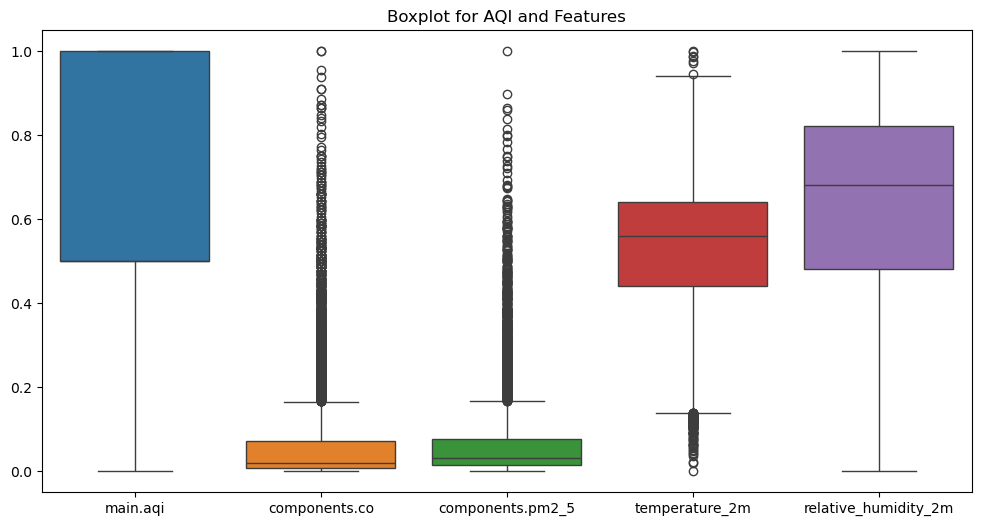

In [207]:
# Boxplots to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df[['main.aqi', 'components.co', 'components.pm2_5', 'temperature_2m', 'relative_humidity_2m']])
plt.title('Boxplot for AQI and Features')
plt.show()
